In [70]:
######## MODULES ##########
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import celia_functions as cf
plt.rcParams.update({'font.size':14, "xtick.direction":"in", "ytick.direction":"in"})
#np.set_printoptions(threshold=sys.maxsize)

pyro_channels = ["Ch1","Ch2","Ch3","Ch4"] # Establishing a catagory of diagnostics will be helpful later.

In [71]:
shotsheet = cf.read_metadata(["SHOT #","Target X","Target Z","TARGET NUMBER","Laser Energy (before comp) [J]"])
targetsheet = cf.read_metadata(["Number","Wheel"])

for key in shotsheet.keys():
    shotsheet[key] = [np.nan if re.search('[^\d.]', str(value)) else float(value) for value in shotsheet[key]] # Filter out all numberic characters. Numeric characters being: `0123456789.`

row_has_data = ~np.all(np.isnan(cf.transform_list(shotsheet.values())), axis = 1)
shotsheet = {key: [cell for cell, cell_has_data in cf.transform_list((column, row_has_data)) if cell_has_data] for key, column in shotsheet.items()} # Filter out any rows that don't have any entries. (all nan rows)

shotsheet["Wheel"] = [targetsheet["Wheel"][targetsheet["Number"].index(target_number)] if target_number in targetsheet["Number"] else np.nan for target_number in shotsheet["TARGET NUMBER"]] # give each target it's respective wheel.
shotsheet["SHOT #"] = [int(shot) for shot in shotsheet["SHOT #"]] #make all shots into intergers. Will fail if there is a nan value.

In [72]:
###Initialisation
target = 0
shotsheet["relative X"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
shotsheet["relative Z"] = np.full(len(shotsheet["SHOT #"]), fill_value= np.nan)
###Loop over all shots
for shot in shotsheet["SHOT #"]:
    s = shotsheet["SHOT #"].index(shot) #find the corrisponding index for this shot. Should be shot -1 = s.
    if shotsheet["TARGET NUMBER"][s] != target:
        delta_x = shotsheet["Target X"][s]
        delta_z = shotsheet["Target Z"][s]
        target = shotsheet["TARGET NUMBER"][s] # ASSUMES THAT WE DON'T RETURN BACK TO THE SAME TARGET.

    shotsheet["relative X"][s] = shotsheet["Target X"][s] -delta_x #make the target movement in x relitive to the first shot
    shotsheet["relative Z"][s] = shotsheet["Target Z"][s] -delta_z #make the target movement in z relitive to the first shot

shotsheet["d"] = np.linalg.norm([shotsheet["relative X"], shotsheet["relative Z"]], axis= 0) # pythagorus to find d. This might be a little simplistic since we know the angle should be 25°

In [73]:
pd.DataFrame(shotsheet)

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,d
0,1,NaN,NaN,1.0,1.700,1.0,NaN,NaN,NaN
1,2,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
2,3,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
3,4,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
4,5,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
261,261,3.345,5.41,125.0,0.806,7.0,1.0,0.51,1.122542
262,262,3.845,5.65,125.0,0.866,7.0,1.5,0.75,1.677051
263,263,4.445,5.97,125.0,0.859,7.0,2.1,1.07,2.356884
264,264,5.045,6.32,125.0,0.794,7.0,2.7,1.42,3.050639


### Choose which targets and channels to use here!

In [74]:
pyro_background = {"Ch1": [99,100,101,102,104,105,107,108,109,110,111,112,113,154,155,156,157,158,159,160,161,162,163,164,165,166,168,169,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,214,215,216,217,218,219,220,221,222,223,224,225,226,227,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265],
                   "Ch2": [114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140141,142,143,144,145,146,147,148,149,150,151,152,153],
                   "Ch3": [70,71,72,74,75,76,77,78,79,80,83,84,85,86,87,88,89,92,93,94,95,96,97,98]}

diagnostics = {"Ch1": shotsheet["SHOT #"],
               "Ch2": shotsheet["SHOT #"],
               "Ch3": shotsheet["SHOT #"],
               "Ch4": shotsheet["SHOT #"],
               "bdot": shotsheet["SHOT #"],
               "xray": shotsheet["SHOT #"],
               "energy": shotsheet["SHOT #"]}

diagnostics_functions = {"Ch1": lambda x: x,
                         "Ch2": lambda x: x,
                         "Ch3": lambda x: x,
                         "Ch4": lambda x: x,
                         "bdot": lambda x: np.ma.masked_invalid(x).ptp(),
                         "tof": np.ptp,
                         "diode": np.ptp,
                         "xray": cf.estimate_xray_signal,
                         "energy": lambda x: x}

background_lookup = {shot: ch for ch, shots in pyro_background.items() for shot in shots} #Create a target -> channel lookup table.

background_data = cf.read_diagnostic_data(pyro_background, silent= False)
diagnostic_data = cf.read_diagnostic_data(diagnostics, functions= diagnostics_functions, silent= False)

Found 121 files:
   290124WIRESHOT100000_Ch1.csv
   290124WIRESHOT101000_Ch1.csv
   290124WIRESHOT102000_Ch1.csv
   290124WIRESHOT104_000_Ch1.csv
   290124WIRESHOT105000_Ch1.csv
   290124WIRESHOT99000_Ch1.csv
   290124WIRESHOT107000_Ch1.csv
   290124WIRESHOT108000_Ch1.csv
   290124WIRESHOT109000_Ch1.csv
   290124WIRESHOT110000_Ch1.csv
   290124WIRESHOT111000_Ch1.csv
   290124WIRESHOT112000_Ch1.csv
   290124WIRESHOT113000_Ch1.csv
   290124WIRESHOT158000_Ch1.csv
   290124WIRESHOT159000_Ch1.csv
   290124WIRESHOT160000_Ch1.csv
   290124WIRESHOT161000_Ch1.csv
   290124WIRESHOT162000_Ch1.csv
   290124WIRESHOT163000_Ch1.csv
   290124WIRESHOT164000_Ch1.csv
   290124WIRESHOT165000_Ch1.csv
   290124WIRESHOT166000_Ch1.csv
   290124WIRESHOT169000_Ch1.csv
   290124WIRESHOT168000_Ch1.csv
   290124WIRESHOT154000_Ch1.csv
   290124WIRESHOT155000_Ch1.csv
   290124WIRESHOT156000_Ch1.csv
   290124WIRESHOT157000_Ch1.csv
   290124WIRESHOT222000_Ch1.csv
   290124WIRESHOT223000_Ch1.csv
   290124WIRESHOT224000

### Background subtraction
Comment this out to remove background subtraction. Only `active_pyro_channels` will be background subtracted. 

In [75]:
active_pyro_channels = np.intersect1d(pyro_channels, list(diagnostic_data.keys()))
for ch in active_pyro_channels:
    for shot in enumerate(shotsheet["SHOT #"]):
        if shot in diagnostic_data["shot"] and shot in background_data["shot"]:
            diagnostic_data[ch][diagnostic_data["shot"].index(shot)] = np.subtract(diagnostic_data[ch][diagnostic_data["shot"].index(shot)], background_data[background_lookup[shot]][background_data["shot"].index(shot)])

### Calculate signal level for the diagnostics
The diagnostic data within `diagnostic_data` also gets merged with the metadata within `shotsheet`.

In [76]:
for key in diagnostic_data.keys():
    if key == "shot": #don't add another shot number to the shotsheet.
        continue 

    if key in pyro_channels:
        diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel

    shotsheet[key] = [diagnostic_data[key][diagnostic_data["shot"].index(shot)] if shot in diagnostic_data["shot"] else np.nan for shot in shotsheet["SHOT #"]] #add diagnostics to the shotsheet on respective shot numbers

C:\Users\syf83691\AppData\Local\Temp\ipykernel_2692\1825345040.py:6: RuntimeWarning: All-NaN axis encountered
  diagnostic_data[key] = [np.abs(np.nanmin(reading)) for reading in diagnostic_data[key]] #find the minima of every pyro channel


In [77]:
pd.DataFrame(shotsheet)

,SHOT #,Target X,Target Z,TARGET NUMBER,Laser Energy (before comp) [J],Wheel,relative X,relative Z,d,Ch1,Ch2,Ch3,Ch4,bdot,xray,energy
0,1,NaN,NaN,1.0,1.700,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.102078,NaN,2.220000e-07
4,5,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.092050,NaN,2.350000e-08
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
261,261,3.345,5.41,125.0,0.806,7.0,1.0,0.51,1.122542,0.192,6.32,0.224,0.144,0.646664,NaN,9.360000e-07
262,262,3.845,5.65,125.0,0.866,7.0,1.5,0.75,1.677051,0.192,4.88,0.240,0.168,0.674602,NaN,9.930000e-07
263,263,4.445,5.97,125.0,0.859,7.0,2.1,1.07,2.356884,0.176,4.08,0.240,0.120,0.649289,NaN,9.300000e-07
264,264,5.045,6.32,125.0,0.794,7.0,2.7,1.42,3.050639,0.096,2.24,0.160,0.084,0.588562,NaN,7.060000e-07


### Normalisation
Comment out line 3 to stop energy normalisation. Comment out line 4 to stop normalisation to the first shot on the target.

In [78]:
unique, indexes, counts = np.unique(shotsheet["TARGET NUMBER"], return_index= True, return_counts= True)
index_of_first_shot_on_this_target = np.repeat(indexes, counts)
nth_shot_on_target = np.concatenate([np.arange(1, count+1) for count in counts])

### loop over all channels
for ch in diagnostics.keys(): #loop over all diagnostic data
    shotsheet[ch] = np.divide(shotsheet[ch], shotsheet["Laser Energy (before comp) [J]"])
    shotsheet[ch] = np.divide(shotsheet[ch], shotsheet[ch][index_of_first_shot_on_this_target])

### Setup parameters for graph

In [79]:
### best fit parameters
number_of_points = 100 #number of points for the best fit line.
#rolling_width = 0.35 #half width. only used by roll_average
confidence= 0.05 #only used by polynomial_fit

x0 = {"Ch1": [1,0],
      "Ch2": [1,0],
      "Ch3": [1,0],
      "Ch4": [1,0],
      "bdot": [1,0],
      "energy": [1,0],
      "xray": [1,0]}

constraints = {"Ch1": None, #[[lower], [upper]]
               "Ch2": None,
               "Ch3": None,
               "Ch4": None,
               "bdot": None, #scipy least_squares doesn't support equality constraints for some reason.
               "energy": None,
               "xray": None}

formatting = {"Ch1": {"colour": "black", "linestyle": "-", "marker": "o"},
              "Ch2": {"colour": "black", "linestyle": "-", "marker": "o"},
              "Ch3": {"colour": "black", "linestyle": "-", "marker": "o"},
              "Ch4": {"colour": "black", "linestyle": "-", "marker": "o"},
              "bdot": {"colour": "crimson", "linestyle": "-.", "marker": "^"},
              "energy": {"colour": "blue", "linestyle": "-", "marker": "s"},
              "xray": {"colour": "forestgreen", "linestyle": ":", "marker": "x"}}

model= cf.polynomial

### Calculate best fit

In [80]:
fit_x, fit_y, fit_delta = {}, {}, {}

for diagnostic in diagnostics:
    fit_x[diagnostic], fit_y[diagnostic], fit_delta[diagnostic] = cf.polynomial_fit(shotsheet["d"],
                                                                                    shotsheet[diagnostic],
                                                                                    number_of_points= number_of_points,
                                                                                    x0= x0[diagnostic],
                                                                                    constraints= constraints[diagnostic],
                                                                                    confidence= confidence,
                                                                                    model_function= model)
    

Optimal coeffients:
1.0340549458331265 -0.011454862823790591
Optimal coeffients:
0.8203632851704017 -0.05418698664403559
Optimal coeffients:
0.8176615019358939 -0.025162159873891362
Optimal coeffients:
0.9656900613447019 -0.08376290808093828
Optimal coeffients:
1.0170417778645633 -0.019347183832220206
Optimal coeffients:
0.9999996231032536 0.09406859617496129
Optimal coeffients:
0.9910489008546395 -0.06423467408600932


### Graph itslef

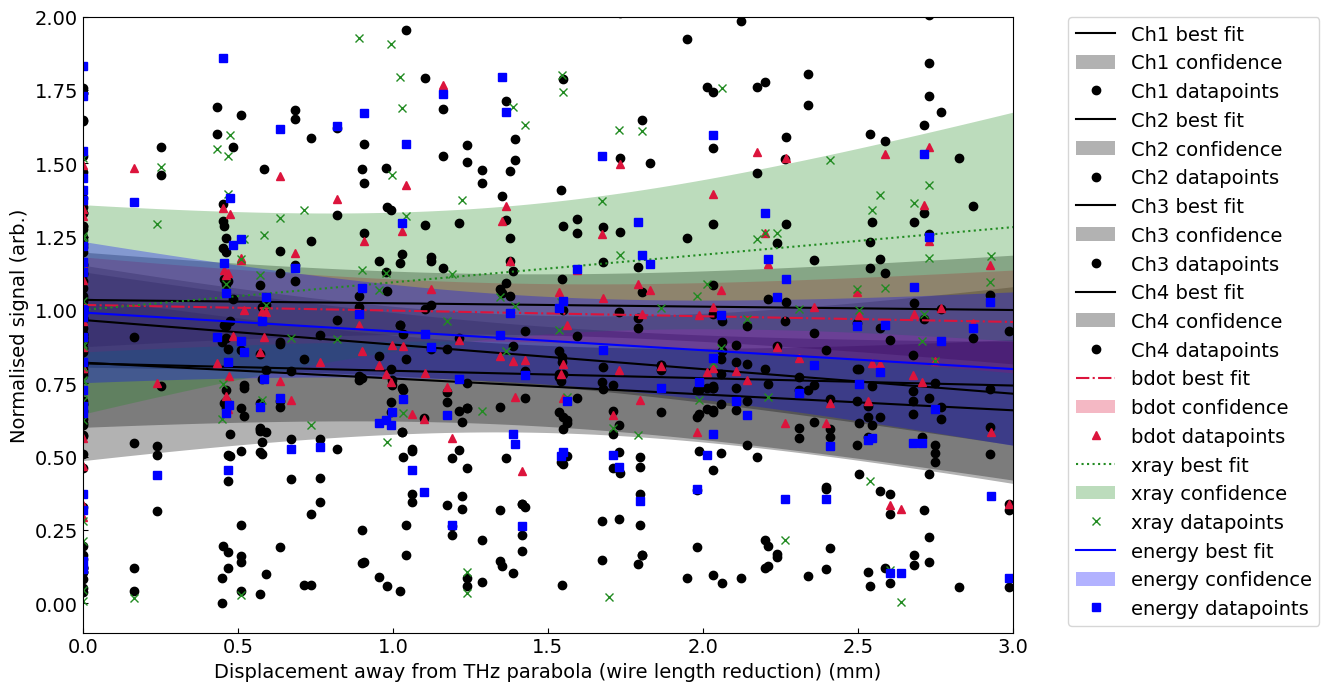

In [84]:
fig, axs = plt.subplots(1, 1, figsize= (12,8))

for diagnostic in diagnostics:

    axs.plot(fit_x[diagnostic],
             fit_y[diagnostic],
             color= formatting[diagnostic]["colour"],
             linestyle= formatting[diagnostic]["linestyle"],
             label= "{0:} best fit".format(diagnostic))
    
    axs.fill_between(fit_x[diagnostic],
                     fit_delta[diagnostic]['lwr_conf'],
                     fit_delta[diagnostic]['upr_conf'],
                     color= formatting[diagnostic]["colour"],
                     edgecolor= "None",
                     alpha= 0.3,
                     label= "{0:} confidence".format(diagnostic))
    
    axs.plot(shotsheet["d"],
             shotsheet[diagnostic],
             color= formatting[diagnostic]["colour"],
             linestyle= "None",
             marker= formatting[diagnostic]["marker"],
             label= "{0:} datapoints".format(diagnostic))
    
targets = np.unique(cf.flatten_list(diagnostics.values()))
axs.set(xlabel= "Displacement away from THz parabola (wire length reduction) (mm)", # x axis label
        ylabel= "Normalised signal (arb.)", # y axis label
        xlim= (0, 3), # x limits
        ylim= (-0.1, 2)) #, #y limits
        #title= "THz, EMP energy and Xrays, normalised for the laser energy, \n relative to the first shot on targets " + ", ".join(targets.astype(str)) + ".") #title

axs.legend(loc= "upper right", bbox_to_anchor= (1.34, 1.015)) # loc fixes the location of the legend. 

plt.show()